# Diversity and Ability
This notebook contains code that supports the analysis of the diversity-expertise tradeoff. The first part analyses the simulation data. The second part provides some numerical examples and a more detailed analysis aimed at providing explanations for the simulation results.  

## Setup

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from models.team import Team
from models.sources import Sources
from models.agent import Agent
import numpy as np
from utils.basic_functions import powerset
from models.generate_teams import generate_diverse_team, generate_expert_team, generate_qualified_diverse_team
from math import comb
from scipy import stats
from data_analysis.statistics import produce_df_1samp, produce_df
from figures_scripts.heatmap import visualize_heatmap

# Statistics and heatmaps
(Note: inspired by [Python for Data Science](https://pythonfordatascienceorg.wordpress.com/paired-samples-t-test-python/) and [Towards Data Science](https://towardsdatascience.com/non-parametric-tests-in-hypothesis-testing-138d585c3548).)

I think that the appropriate *non-parametric* statistical test is the Wilcoxon test ([Wikipedia](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test)). When comparing the expert team to a set of diverse teams, we use the one-sample Wilcoxon test. When comparing the performance of the diverse team for different deliberative mechanisms, we use the paired Wilcoxon test. 

## Results in tabular form

In [ ]:
produce_df(outcome="accuracy", team_type="qualified_diverse_90", date="2025")

,n_sources,rel_mean,accuracy,std
0,13,0.55,70.0,0.2
1,13,0.60,80.4,0.1
2,13,0.65,88.5,0.1
3,13,0.70,94.2,0.1
4,13,0.75,97.6,0.0


In [49]:
produce_df(outcome="accuracy", team_type="expert")

,n_sources,rel_mean,accuracy,std
0,13,0.55,71.8,0
1,13,0.60,80.3,0
2,13,0.65,87.4,0
3,13,0.70,92.8,0
4,13,0.75,96.5,0
5,17,0.55,73.6,0
6,17,0.60,81.8,0
7,17,0.65,88.5,0
8,17,0.70,93.6,0
9,17,0.75,97.0,0


In [16]:
produce_df(outcome="bounded_pool_accuracy", team_type="diverse")

,n_sources,rel_mean,bounded_pool_accuracy,std
0,13,0.55,64.4,0.3
1,13,0.60,77.1,0.3
2,13,0.65,87.1,0.2
3,13,0.70,93.8,0.1
4,13,0.75,97.6,0.1
5,17,0.55,66.1,0.8
6,17,0.60,79.8,0.6
7,17,0.65,89.8,0.4
8,17,0.70,95.8,0.2
9,17,0.75,98.7,0.1


In [3]:
produce_df_1samp("accuracy", n_decimals=5)


,n_sources,rel_mean,p_value,statistic,difference,error_reduction,std
0,13,0.55,0.0000,0.0,-0.08068,-28.6,0.007916
1,13,0.60,0.0000,0.0,-0.04316,-21.9,0.006814
2,13,0.65,0.0000,5.0,-0.01535,-12.2,0.005346
3,13,0.70,0.1626,24599385.0,0.00002,0.0,0.003635
4,13,0.75,0.0000,83001.0,0.00457,15.0,0.002091
5,17,0.55,0.0000,0.0,-0.08345,-31.6,0.008406
6,17,0.60,0.0000,0.0,-0.03320,-18.3,0.006797
7,17,0.65,0.0000,22503425.0,-0.00049,-0.4,0.004878
8,17,0.70,0.0000,0.0,0.01266,24.6,0.002892
9,17,0.75,0.0000,0.0,0.01198,66.2,0.001399


In [4]:
produce_df_1samp("pool_accuracy")

,n_sources,rel_mean,p_value,statistic,difference,error_reduction,std
0,13,0.55,0,NaN,-0.054,-17.7,NaN
1,13,0.60,0,NaN,-0.027,-13.4,NaN
2,13,0.65,0,NaN,-0.008,-6.6,NaN
3,13,0.70,0,NaN,0.002,2.7,NaN
4,13,0.75,0,NaN,0.004,15.8,NaN
5,17,0.55,0,NaN,-0.070,-26.4,NaN
6,17,0.60,0,NaN,-0.026,-15.1,NaN
7,17,0.65,0,NaN,0.001,0.8,NaN
8,17,0.70,0,NaN,0.010,24.7,NaN
9,17,0.75,0,NaN,0.008,66.0,NaN


In [5]:
produce_df_1samp("bounded_pool_accuracy")

,n_sources,rel_mean,p_value,statistic,difference,error_reduction,std
0,13,0.55,0.0,0.0,-0.074,-26.4,0.003263
1,13,0.60,0.0,0.0,-0.032,-16.0,0.002793
2,13,0.65,0.0,2653359.0,-0.002,-1.9,0.002153
3,13,0.70,0.0,0.0,0.011,17.5,0.001428
4,13,0.75,0.0,0.0,0.012,48.2,0.000805
5,17,0.55,0.0,0.0,-0.075,-28.4,0.007517
6,17,0.60,0.0,0.0,-0.019,-10.7,0.005960
7,17,0.65,0.0,94.0,0.013,13.0,0.004137
8,17,0.70,0.0,0.0,0.023,54.1,0.002329
9,17,0.75,0.0,0.0,0.017,131.9,0.001042


## Heatmaps

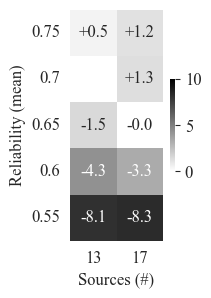

In [6]:
visualize_heatmap(outcome="accuracy", show=True)

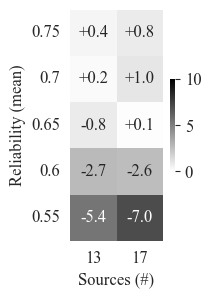

In [7]:
visualize_heatmap(outcome="pool_accuracy", show=True)

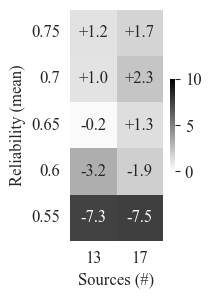

In [8]:
visualize_heatmap(outcome="bounded_pool_accuracy", show=True)

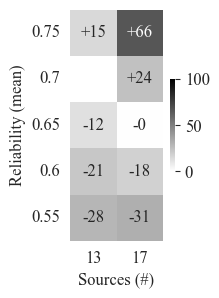

In [9]:
visualize_heatmap(outcome="accuracy", measure="relative", show=True)

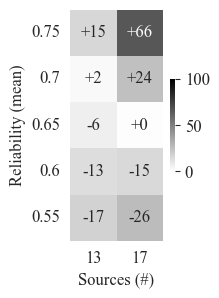

In [10]:
visualize_heatmap(outcome="pool_accuracy", measure="relative", show=True)

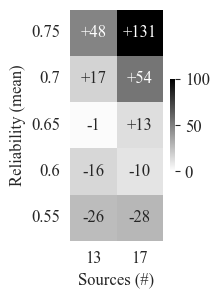

In [11]:
visualize_heatmap(outcome="bounded_pool_accuracy", measure="relative", show=True)

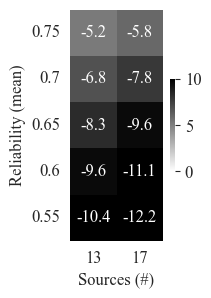

In [12]:
visualize_heatmap(outcome="average", measure="absolute", show=True)

# Explanations for the results

## Some examples
In this section, we treat some examples to demonstrate that diversity sometimes trumps expertise, and _vice versa_.

Numerical example with a few highly reliable and the others are randomizers

In [32]:
sources = Sources(18)
reliabilities = 0.50* np.ones(14) 
reliabilities = np.append(reliabilities, [0.9, 0.9, 0.9, 0.9])
sources.reliabilities = reliabilities
team_size = 3
e_team = generate_expert_team(sources, 3, team_size)
d_team = generate_diverse_team(sources, 3, team_size)
print(f"Expert team accuracy: {e_team.accuracy()[0]:.3f}")
print(f"Diverse team accuracy: {d_team.accuracy()[0]:.3f}")
print(f"Expert team pool accuracy: {e_team.pool_accuracy():.3f}")
print(f"Diverse team pool accuracy: {d_team.pool_accuracy():.3f}")
print(f"Expert team bounded pool accuracy: {e_team.bounded_pool_accuracy():.3f}")
print(f"Diverse team bounded pool accuracy: {d_team.bounded_pool_accuracy():.3f}")

Expert team accuracy: 0.972
Diverse team accuracy: 0.700
Expert team pool accuracy: 0.972
Diverse team pool accuracy: 0.719
Expert team bounded pool accuracy: 0.972
Diverse team bounded pool accuracy: 0.719


Numerical example where sources are approximately equally reliable.

In [33]:
sources = Sources(18)
reliabilities = 0.59* np.ones(14) 
reliabilities = np.append(reliabilities, 0.6 * np.ones(4))
sources.reliabilities = reliabilities
team_size = 3
e_team = generate_expert_team(sources, 3, team_size)
d_team = generate_diverse_team(sources, 3, team_size)
print(f"Expert team accuracy: {e_team.accuracy()[0]:.3f}")
print(f"Diverse team accuracy: {d_team.accuracy()[0]:.3f}")
print(f"Expert team pool accuracy: {e_team.pool_accuracy():.3f}")
print(f"Diverse team pool accuracy: {d_team.pool_accuracy():.3f}")
print(f"Expert team bounded pool accuracy: {e_team.bounded_pool_accuracy():.3f}")
print(f"Diverse team bounded pool accuracy: {d_team.bounded_pool_accuracy():.3f}")

Expert team accuracy: 0.648
Diverse team accuracy: 0.700
Expert team pool accuracy: 0.648
Diverse team pool accuracy: 0.717
Expert team bounded pool accuracy: 0.648
Diverse team bounded pool accuracy: 0.717


Defending the decision to consider reliability means of maximally 75%. Calculating the highest individual score for this setting. 

In [34]:
sources = Sources(21, reliability_distribution=("equidist", (0.65, 0.85)))
e_team = generate_expert_team(sources, 5, 9)

for agent in e_team.members:
    print(f"Score: {agent.score:.5f}")

Score: 0.96269
Score: 0.96155
Score: 0.96041
Score: 0.96035
Score: 0.95927
Score: 0.95919
Score: 0.95910
Score: 0.95813
Score: 0.95802


## Individual scores
In this section, we study the individual scores in different parameter settings. Our analysis shows that we can interpret the parameter settings in multiple ways: in terms of the sources’ reliabilities, the problem’s difficulty, and/or the knowledge and skills of the pool of agents. 

In [16]:
from figures_scripts.individual_scores import df_individual_scores, boxplot_individual_scores

A visualization of the distribution of individual scores of all possible heuristics

Difficulty: 0.8030
Best agent: 0.8025
Team size: 6,188


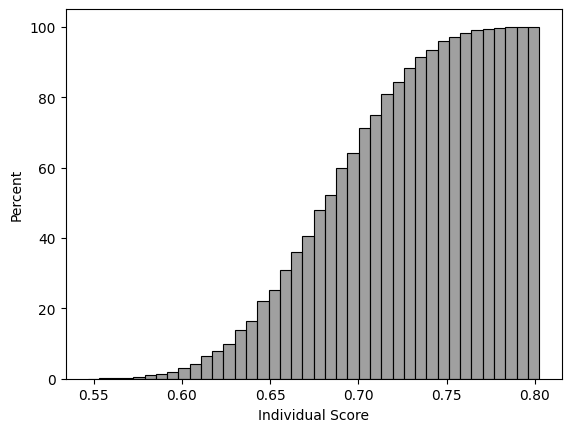

In [35]:
from math import comb

n_sources = 17
sources = Sources(n_sources, reliability_distribution=("equidist", (0.50, 0.70)))

ranked_agents = generate_expert_team(sources, 5, comb(n_sources, 5))

scores = np.array([agent.score for agent in ranked_agents.members])
fig = sns.histplot(scores, bins= 40, stat="percent", cumulative=True, color="gray")
fig.set_xlabel("Individual Score")

print(f"Difficulty: {sources.problem_difficulty():.4f}")
best_agent = ranked_agents.members[0]
print(f"Best agent: {best_agent.score:.4f}")
print(f"Team size: {ranked_agents.size:,}")
# print(f"Team score: {ranked_agents.accuracy()}")

In [18]:
df_individual_scores()

,n_sources,rel_mean,mean,std,max,min
0,13.0,0.55,0.593368,0.041962,0.711170,0.468738
1,13.0,0.60,0.683028,0.039469,0.790432,0.562384
2,13.0,0.65,0.765496,0.035485,0.858625,0.653550
3,13.0,0.70,0.837739,0.030266,0.913674,0.738659
4,13.0,0.75,0.897398,0.024171,0.954478,0.814513
5,17.0,0.55,0.593301,0.043674,0.724930,0.453174
6,17.0,0.60,0.682898,0.041081,0.802493,0.546826
7,17.0,0.65,0.765311,0.036937,0.868592,0.638616
8,17.0,0.70,0.837512,0.031510,0.921302,0.724930
9,17.0,0.75,0.897145,0.025172,0.959710,0.802493


In [19]:
boxplot_individual_scores()

## Diversity and disagreement
In this section, we determine (a) the difference in diversity between the expert and diverse team, and (b) the rate of disagreement between experts. We show that the expert team is very homogenous and that disagreement between experts is rare. 

In [20]:
from models.sources import Sources
from models.agent import Agent
from models.generate_teams import generate_expert_team, generate_diverse_team
from math import comb
import numpy as np
import pandas as pd
from utils.basic_functions import calculate_diversity, powerset
import utils.config as cfg

In [21]:
sources = Sources(13)
e_team = generate_expert_team(sources, 5, 9)
d_team = generate_diverse_team(sources, 5, 9)
e_diversities = [calculate_diversity(a.heuristic, b.heuristic) for a in e_team.members for b in e_team.members]
d_diversities = [calculate_diversity(a.heuristic, b.heuristic) for a in d_team.members for b in d_team.members]
print(f"Diversity gap for 13 sources {d_team.diversity() - e_team.diversity()}")

sources = Sources(17)
e_team = generate_expert_team(sources, 5, 9)
d_team = generate_diverse_team(sources, 5, 9)
e_diversities = [calculate_diversity(a.heuristic, b.heuristic) for a in e_team.members for b in e_team.members]
d_diversities = [calculate_diversity(a.heuristic, b.heuristic) for a in d_team.members for b in d_team.members]
print(f"Diversity gap for 17 sources {d_team.diversity() - e_team.diversity()}")



Diversity gap for 13 sources 0.40555555555555556
Diversity gap for 17 sources 0.5055555555555555


In [22]:
def likelihood_disagreement(agent1: Agent, agent2: Agent):
    sources = agent1.sources
    p_disagreement: float = 0
    sources_relevant = np.unique(agent1.heuristic + agent2.heuristic)
    
    for sources_positive in powerset(sources_relevant):
        for source in sources.sources:
            sources.set_valence(source, cfg.vote_for_negative)
        for source in sources_positive:
            sources.set_valence(source, cfg.vote_for_positive)
        agent1.update_opinion()
        agent2.update_opinion()
        if agent1.opinion != agent2.opinion:
            probabilities_list = [
                sources.reliabilities[source] for source in sources_positive
            ] + [
                1 - sources.reliabilities[source]
                for source in sources_relevant
                if source not in sources_positive
            ]
            probability_subset = np.prod(probabilities_list)
            p_disagreement += probability_subset            
    return p_disagreement

In [23]:
def calculate_expert_disagreement(n_sources, rel_mean):
    sources = Sources(n_sources, ("equi", (rel_mean - 0.1 , rel_mean + 0.1)))
    e_team = generate_expert_team(sources, 5, 9)
    disagreements = [likelihood_disagreement(a, b) for a in e_team.members for b in e_team.members]
    return max(disagreements)
    

In [24]:
data = [
    [n_sources, rel_mean, calculate_expert_disagreement(n_sources, rel_mean)]
    for n_sources in [13, 17]
    for rel_mean in 0.55 + 0.05 * np.arange(5)
]
df = pd.DataFrame(data, columns=["n_sources", "rel_mean", "disagreement_rate"])
df


,n_sources,rel_mean,disagreement_rate
0,13,0.55,0.247400
1,13,0.60,0.210279
2,13,0.65,0.164766
3,13,0.70,0.116473
4,13,0.75,0.071405
5,17,0.55,0.239819
6,17,0.60,0.200227
7,17,0.65,0.153578
8,17,0.70,0.105629
9,17,0.75,0.062307


## Expert team versus best-performing individual
In this section, we compare the performance of the expert team and the best-performing _individual_. We show that the difference is tiny, indicating that the expert team and the best-performing individual are virtually identical. 

In [25]:
from data_analysis.expert_team_vs_individual import produce_df_expert_team_individual

In [26]:
produce_df_expert_team_individual(outcome="accuracy")

,n_sources,rel_mean,difference,error_reduction
0,13,0.55,-0.007,-2
1,13,0.60,-0.013,-6
2,13,0.65,-0.015,-12
3,13,0.70,-0.014,-20
4,13,0.75,-0.011,-30
5,17,0.55,-0.011,-4
6,17,0.60,-0.016,-9
7,17,0.65,-0.017,-15
8,17,0.70,-0.015,-23
9,17,0.75,-0.010,-34


In [27]:
produce_df_expert_team_individual(outcome="bounded_pool_accuracy")

,n_sources,rel_mean,difference,error_reduction
0,13,0.55,-0.007,-2
1,13,0.60,-0.012,-6
2,13,0.65,-0.015,-12
3,13,0.70,-0.014,-19
4,13,0.75,-0.010,-29
5,17,0.55,-0.011,-4
6,17,0.60,-0.015,-8
7,17,0.65,-0.016,-14
8,17,0.70,-0.014,-22
9,17,0.75,-0.010,-32


## Overcounting: Boundedly rational evidence-based dynamics
In this section, we study the boundedly rational evidence-based dynamics and, in particular, the exact weights in expert teams and diverse teams. We show that the expert team puts virtually all the weight on the best evidences, while the diverse team spreads the weight (approximately) equally among all evidences. 

In [28]:
from models.generate_teams import generate_expert_team, generate_diverse_team

sources = Sources(17)
e_team = generate_expert_team(sources, 5, 9)

expert_coverage, expert_weights = np.unique([agent.heuristic for agent in e_team.members], return_counts=True)
dict(zip(expert_coverage, expert_weights))


{8: 1, 9: 2, 10: 2, 11: 3, 12: 5, 13: 6, 14: 8, 15: 9, 16: 9}

In [29]:
d_team = generate_diverse_team(sources, 5, 9)

coverage, weights = np.unique([agent.heuristic for agent in d_team.members], return_counts=True)
dict(zip(coverage, weights))

# for k in a:
#     print(k)

{0: 3,
 1: 3,
 2: 3,
 3: 2,
 4: 2,
 5: 2,
 6: 3,
 7: 3,
 8: 3,
 9: 3,
 10: 2,
 11: 3,
 12: 3,
 13: 3,
 14: 2,
 15: 3,
 16: 2}

In [46]:
d_team = generate_qualified_diverse_team(sources, 5, 9, qualifying_percentile=10)

coverage, weights = np.unique([agent.heuristic for agent in d_team.members], return_counts=True)
dict(zip(coverage, weights))

{0: 3,
 1: 3,
 2: 3,
 3: 3,
 4: 3,
 5: 2,
 6: 2,
 7: 2,
 8: 3,
 9: 2,
 10: 2,
 11: 3,
 12: 3,
 13: 3,
 14: 2,
 15: 3,
 16: 3}

In [47]:
d_team = generate_qualified_diverse_team(sources, 5, 9, qualifying_percentile=90)

coverage, weights = np.unique([agent.heuristic for agent in d_team.members], return_counts=True)
dict(zip(coverage, weights))

{0: 1,
 2: 1,
 3: 1,
 4: 2,
 5: 1,
 6: 2,
 7: 2,
 8: 3,
 9: 3,
 10: 3,
 11: 4,
 12: 4,
 13: 4,
 14: 4,
 15: 5,
 16: 5}